## Cargando los datasets

In [1]:
from datasets.classification_dataset import DermaClassificationDataset
from pathlib import Path
import pandas as pd

def get_dataset_image_root() -> Path:
    """Returns the path to the root of the classification dataset"""
    return Path("./images/classification/")

def get_classification_csv_path() -> Path:
    """Returns the path to the csv file containing the information about the images
    and their classifications"""
    return Path("./datasets/csv_files/clean_classification_dataset.csv")


In [2]:
# from sklearn.model_selection import train_test_split
from utils.splitters import train_test_split_for_unbalanced_dataframes


all_images_df = pd.read_csv(get_classification_csv_path())
# train_files, val_files = train_test_split(all_images_df, test_size=0.2, random_state=42)
train_files, test_files = train_test_split_for_unbalanced_dataframes(all_images_df, test_percentage=0.2, column_name="metaclass", seed=35)

train_files, val_files = train_test_split_for_unbalanced_dataframes(train_files, test_percentage=0.16, column_name="metaclass", seed=35)

print(f"Size of training images: {len(train_files)}")
print(f"Size of validation images: {len(val_files)}")
print(f"Size of test images: {len(test_files)}")

Size of training images: 35429
Size of validation images: 6750
Size of test images: 10547


In [14]:
from preprocessing.dataset_transforms import (
    get_classification_train_transforms_v2,
    get_classification_evaluation_transform_v2,
)

train_transform = get_classification_train_transforms_v2(
    image_size=(224, 224), dull_razor_probability=0.5
)
val_transform = get_classification_evaluation_transform_v2()

all_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=all_images_df,
    transform=None,
)

train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=train_transform,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=val_transform,
)

test_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=test_files,
    transform=val_transform
)

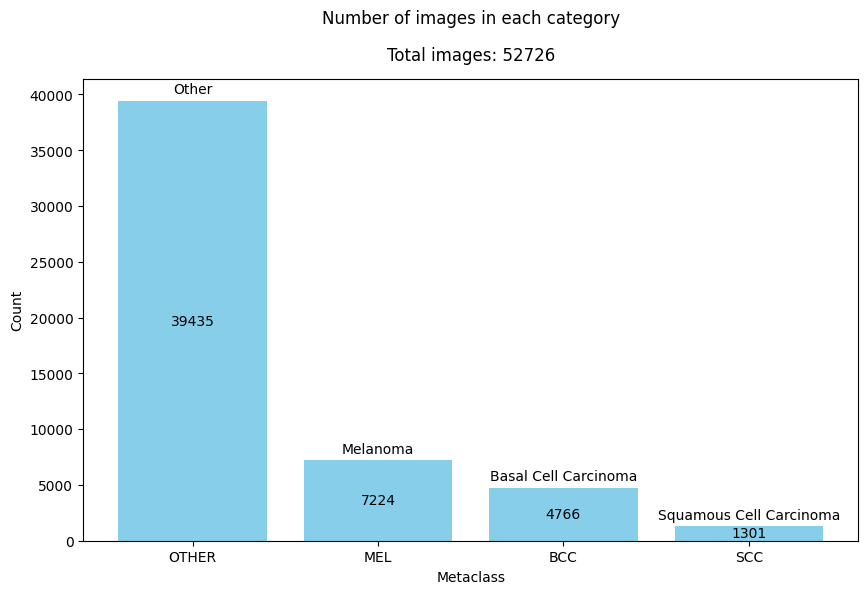

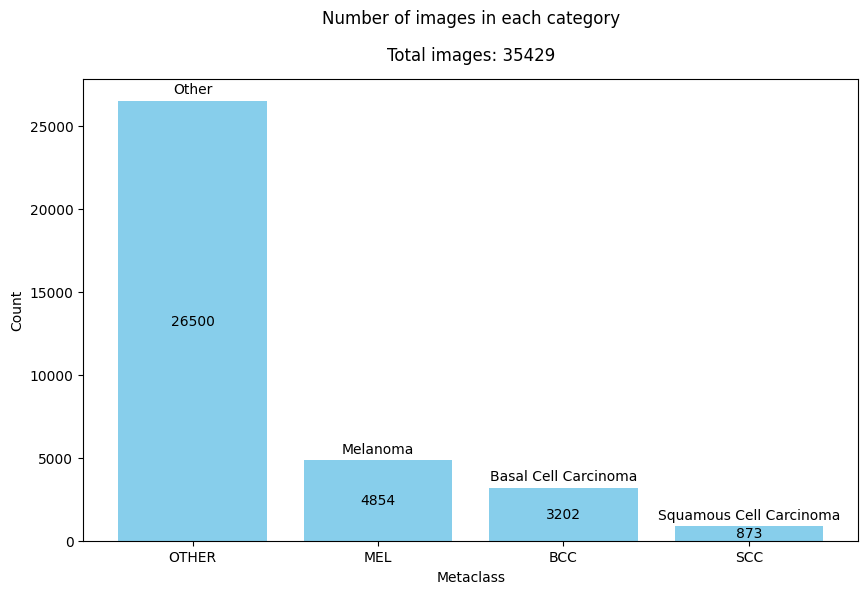

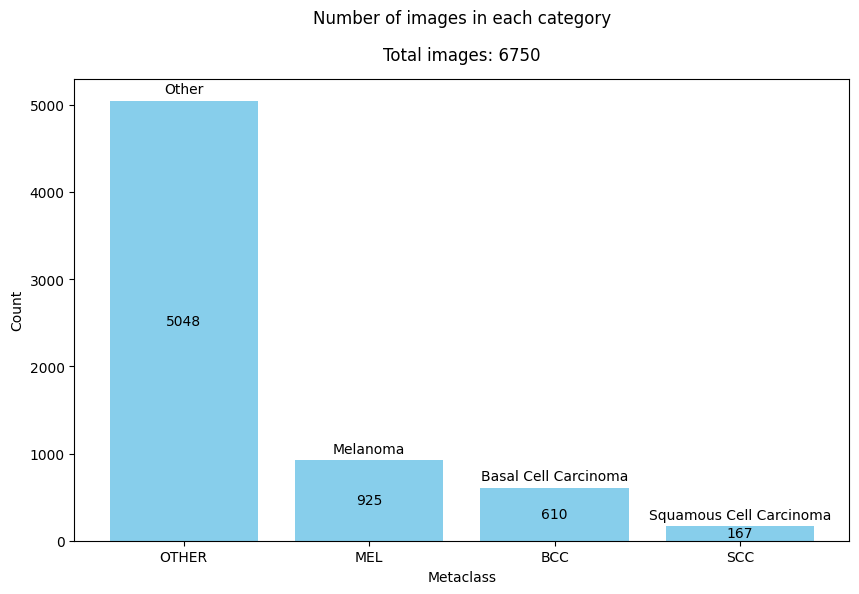

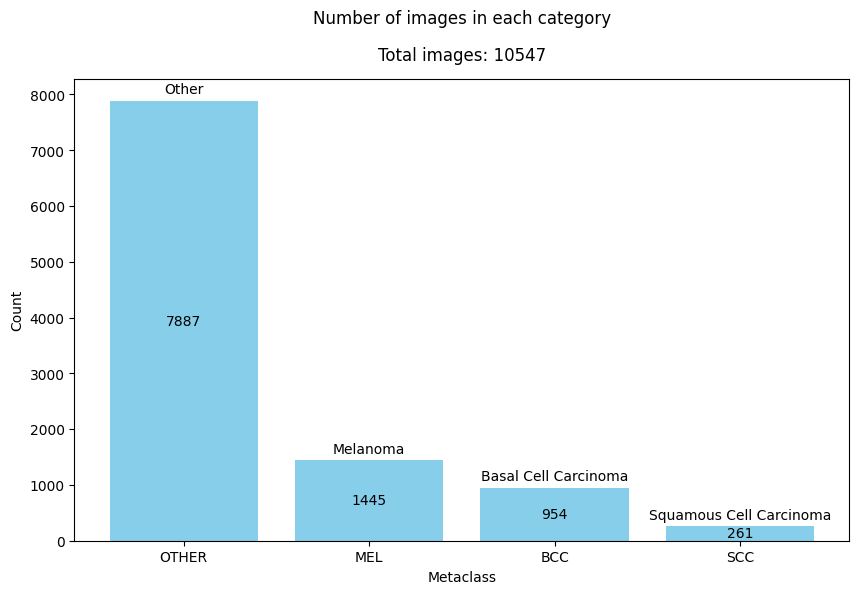

In [15]:
all_dataset.plot_class_distribution()
train_dataset.plot_class_distribution()
val_dataset.plot_class_distribution()
test_dataset.plot_class_distribution()

### Creando los dataloaders

In [5]:
train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=8)

val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=8)

  0%|          | 0/35429 [00:00<?, ?it/s]

100%|██████████| 35429/35429 [00:00<00:00, 766987.52it/s]


In [6]:
print(len(train_dl))

1108


In [8]:
from tqdm import tqdm

def get_image_counts_by_category(dataloader):
    """
    Returns a dictionary with the count of images in each category from the given DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader to analyze.

    Returns:
        dict: A dictionary where each key is a category (as an integer) and the value is the total count of images in that category.
    """
    category_counts = {}

    # Iterate over the DataLoader
    for index, batch in tqdm(enumerate(dataloader), total=len(dataloader), colour="blue", leave=True):
        _, labels = batch

        # Iterate over the labels in the batch
        for label in labels:
            label = label.item()  # Convert tensor to integer
            if label in category_counts:
                category_counts[label] += 1
            else:
                category_counts[label] = 1

    return category_counts

In [9]:
first = get_image_counts_by_category(train_dl)
second = get_image_counts_by_category(val_dl)

print(f"The first dataloader have the following distribution:\n\t{first.items()}")
print(f"The second dataloader have the following distribution:\n\t{second.items()}")

100%|██████████| 211/211 [00:22<00:00,  9.54it/s]

The first dataloader have the following distribution:
	dict_items([(3, 8892), (1, 8884), (2, 8869), (0, 8784)])
The second dataloader have the following distribution:
	dict_items([(2, 5048), (0, 610), (1, 925), (3, 167)])


### Calculando la media y desviación estándar del dataset de entrenamiento

In [11]:
import torch


def get_mean_std(loader):
    """Get the mean and std of an image dataset given."""
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for _, (data, _) in tqdm(
        enumerate(loader),
        desc=f"Calculating the mean and std of the dataloader",
        total=len(loader),
        colour="blue",
    ):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std

In [12]:
import torchvision.transforms.v2 as transforms

basic_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
    ]
)

train_basic = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=basic_transform,
)

train_basic_dl = train_basic.get_basic_dataloader(batch_size=32,num_workers=8)

In [11]:
# mean, std = get_mean_std(train_basic_dl)

Calculating the mean and std of the dataloader: 100%|██████████| 1108/1108 [03:34<00:00,  5.17it/s]


In [12]:
# print(f"The mean is:\n{mean}")

# print(f"The std is:\n{std}")

The mean is:
tensor([0.6900, 0.5422, 0.5210])
The std is:
tensor([0.1948, 0.1797, 0.1941])


## Exploracion breve del dataset

In [10]:
from utils.graphic_tools import ClassificationImgHelper
from utils.cache_image_folder import CacheImgFolder

cache = CacheImgFolder(
    root_image_folder=get_dataset_image_root(),
)
cache.disable_cache()

helper = ClassificationImgHelper(
    dataframe=train_files,
    get_category=lambda df, cat: df[df["metaclass"] == cat],
    cache=cache,
    get_image_path=lambda df: df["image_path"],
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3879551..1.6324173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7009164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2214233].


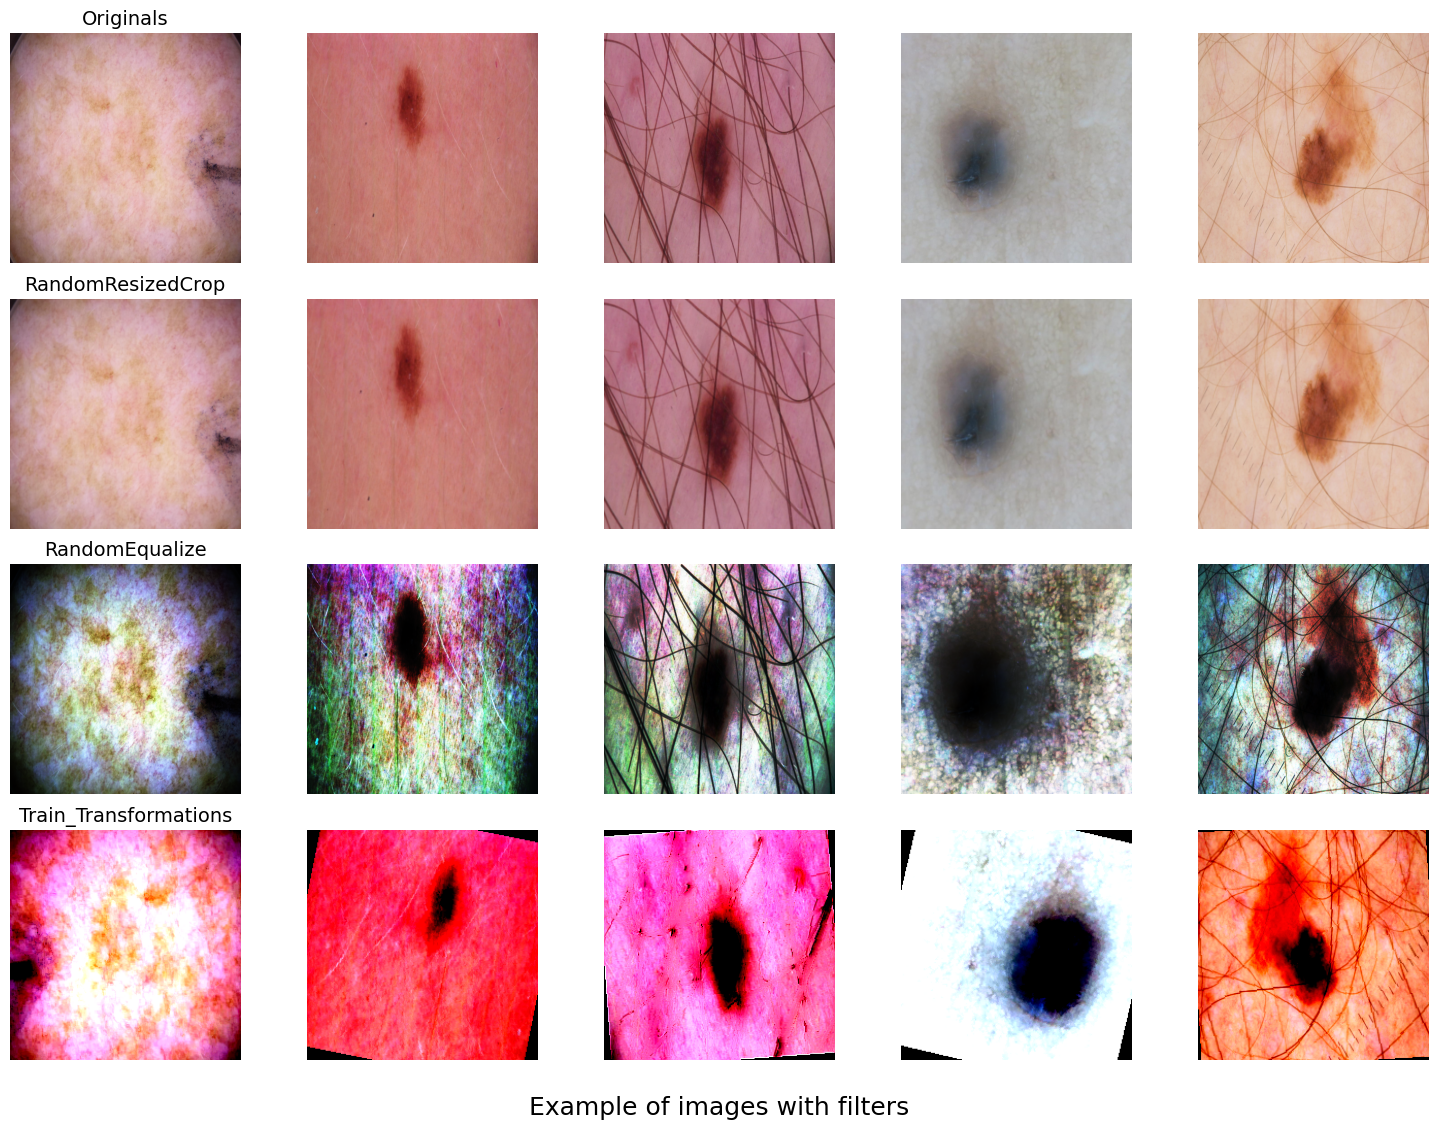

In [13]:
from preprocessing.dull_razor import RandomDullRazor
import torchvision.transforms.v2 as transforms

helper.plot_random_sample_with_filters(
    amount=5,
    filters=[
        (
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            "RandomResizedCrop",
        ),
        (
            transforms.RandomEqualize(1),
            "RandomEqualize"
        ),
        (
            get_classification_train_transforms_v2(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # get_classification_train_transforms_v2(mean=(0.6896, 0.5420, 0.5206), std=(0.1942, 0.1794, 0.1939)),
            "Train_Transformations",
        )
    ],
    seed=45,
)

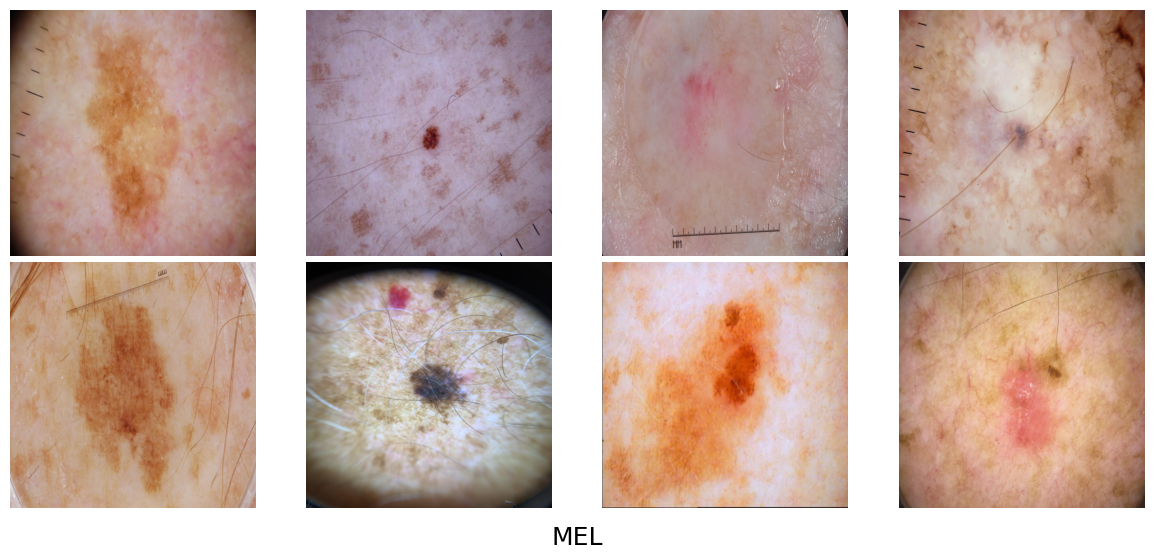

In [15]:
helper.plot_random_sample_of_category(
    category="MEL",
    amount=8,
    seed=10,
)

## Entrenamiento

In [8]:
from models.resnet_transfer_learning import get_resnet50
import torchsummary
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, loss, optimizer = get_resnet50(4)


In [ ]:
torchsummary.summary(
    model,
    input_data=(3,224,224)
)

### Funciones de utilidad para el entrenamiento

In [9]:
def train_batch(x, y, model, optimizer, criteria):
    """Train a batch of data and return the loss value and accuracy"""
    model.train()
    optimizer.zero_grad()
    prediction = model(x)
    batch_loss = criteria(prediction, y)
    batch_loss.backward()
    optimizer.step()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    _, argmaxes = prediction.max(-1)
    correct_predictions = (y == argmaxes).sum().item()
    total_examples = y.size(0)
    return correct_predictions, total_examples

@torch.no_grad()
def validation_loss(x, y, model, criteria):
    """Validate a batch of data and return the loss value and the number of correct predictions"""
    model.eval()
    prediction = model(x)
    batch_loss = criteria(prediction, y)
    return batch_loss.item()
    

In [11]:
import shutil

def train_epochs(
    model,
    optimizer,
    criteria,
    train_dl,
    val_dl,
    epochs=10,
    save_every_epoch:int = 3,
    save_path: Path = Path("./saved_models"),
):
    if save_path.exists():
        shutil.rmtree(save_path)
    save_path.mkdir(parents=True, exist_ok=True)
    """Train the model for a number of epochs"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Initialize metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for _, batch in tqdm(
            enumerate(train_dl),
            total=len(train_dl),
            desc=f"Training epoch {epoch+1}/{epochs}",
            colour="red",
        ):
            x, y = batch
            x, y = x.to(device=device), y.to(device=device)
            total_train_loss += train_batch(x, y, model, optimizer, criteria)
            correct, batch_size = accuracy(x, y, model)
            total_train_correct += correct
            total_train_samples += batch_size

        train_loss = total_train_loss / len(train_dl)
        train_accuracy = total_train_correct / total_train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.4f}")

        # Initialize validation metrics
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        for _, batch in tqdm(
            enumerate(val_dl),
            total=len(val_dl),
            desc=f"Validation on {epoch+1}/{epochs}",
            colour="green",
        ):
            x, y = batch
            x, y = x.to(device=device), y.to(device=device)
            total_val_loss += validation_loss(x, y, model, criteria)
            correct, batch_size = accuracy(x, y, model)
            total_val_correct += correct
            total_val_samples += batch_size

        val_loss = total_val_loss / len(val_dl)
        val_accuracy = total_val_correct / total_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if (epoch + 1) in (1, epochs) or (epoch + 1) % save_every_epoch == 0:
            model.to("cpu")
            torch.save(model.state_dict(), save_path/f"model_epoch_{epoch + 1}.pth")
            model.to(device)
    return train_losses, train_accuracies, val_losses, val_accuracies

### Experimento 1

In [20]:
from preprocessing.dull_razor import RandomDullRazor

train_transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224),  # Default is (512,512)
            antialias=True,
        ),
        RandomDullRazor.from_image_size(
            (224, 224),
            probability=0.5,
        ),
        transforms.ColorJitter(
            brightness=(0.8, 1.2),  # Rango de valores: 0.0 a 1.0 o un solo valor
            contrast=(0.8, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            saturation=(0.8, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            hue=(-0.02, 0.02),  # Rango de valores: -0.5 a 0.5
        ),
        transforms.RandomAffine(
            degrees=(-15, 15),
            scale=(1.0, 1.2),
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224),
            antialias=True,
        ),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=train_transform,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=val_transform,
)

In [15]:
train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model=model,
    optimizer=optimizer,
    criteria=loss,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=16,
    save_every_epoch=3,
    save_path=Path("./saved_models/experiment_1"),
)

Training epoch 1/16: 100%|██████████| 1319/1319 [12:40<00:00,  1.73it/s]

Training Loss: 0.9185
Training Accuracy: 0.6417



Validation on 1/16: 100%|██████████| 330/330 [04:15<00:00,  1.29it/s]


Validation Loss: 0.6929
Validation Accuracy: 0.6875


Training epoch 2/16: 100%|██████████| 1319/1319 [18:48<00:00,  1.17it/s]

Training Loss: 0.8398
Training Accuracy: 0.6815



Validation on 2/16: 100%|██████████| 330/330 [04:15<00:00,  1.29it/s]

Validation Loss: 0.7294
Validation Accuracy: 0.6734



Training epoch 3/16: 100%|██████████| 1319/1319 [18:59<00:00,  1.16it/s]

Training Loss: 0.8116
Training Accuracy: 0.6987



Validation on 3/16: 100%|██████████| 330/330 [04:30<00:00,  1.22it/s]

Validation Loss: 0.7728
Validation Accuracy: 0.6389



Training epoch 4/16: 100%|██████████| 1319/1319 [18:47<00:00,  1.17it/s]

Training Loss: 0.7797
Training Accuracy: 0.7111



Validation on 4/16: 100%|██████████| 330/330 [04:21<00:00,  1.26it/s]


Validation Loss: 0.7550
Validation Accuracy: 0.6625


Training epoch 5/16: 100%|██████████| 1319/1319 [18:29<00:00,  1.19it/s]

Training Loss: 0.7660
Training Accuracy: 0.7234



Validation on 5/16: 100%|██████████| 330/330 [04:27<00:00,  1.23it/s]

Validation Loss: 0.6561
Validation Accuracy: 0.7041



Training epoch 6/16: 100%|██████████| 1319/1319 [18:51<00:00,  1.17it/s]

Training Loss: 0.7472
Training Accuracy: 0.7361



Validation on 6/16: 100%|██████████| 330/330 [04:18<00:00,  1.28it/s]

Validation Loss: 0.7411
Validation Accuracy: 0.6542



Training epoch 7/16: 100%|██████████| 1319/1319 [18:28<00:00,  1.19it/s]

Training Loss: 0.7364
Training Accuracy: 0.7421



Validation on 7/16: 100%|██████████| 330/330 [04:20<00:00,  1.27it/s]


Validation Loss: 0.6731
Validation Accuracy: 0.7017


Training epoch 8/16: 100%|██████████| 1319/1319 [18:29<00:00,  1.19it/s]

Training Loss: 0.7321
Training Accuracy: 0.7459



Validation on 8/16: 100%|██████████| 330/330 [04:30<00:00,  1.22it/s]

Validation Loss: 0.6722
Validation Accuracy: 0.6923



Training epoch 9/16: 100%|██████████| 1319/1319 [18:33<00:00,  1.18it/s]

Training Loss: 0.7200
Training Accuracy: 0.7536



Validation on 9/16: 100%|██████████| 330/330 [04:28<00:00,  1.23it/s]

Validation Loss: 0.6667
Validation Accuracy: 0.6854



Training epoch 10/16: 100%|██████████| 1319/1319 [18:32<00:00,  1.19it/s]

Training Loss: 0.7035
Training Accuracy: 0.7615



Validation on 10/16: 100%|██████████| 330/330 [04:25<00:00,  1.24it/s]


Validation Loss: 0.6573
Validation Accuracy: 0.7039


Training epoch 11/16: 100%|██████████| 1319/1319 [18:45<00:00,  1.17it/s]

Training Loss: 0.7006
Training Accuracy: 0.7643



Validation on 11/16: 100%|██████████| 330/330 [04:28<00:00,  1.23it/s]

Validation Loss: 0.6231
Validation Accuracy: 0.7178



Training epoch 12/16: 100%|██████████| 1319/1319 [18:39<00:00,  1.18it/s]

Training Loss: 0.6900
Training Accuracy: 0.7691



Validation on 12/16: 100%|██████████| 330/330 [04:12<00:00,  1.31it/s]

Validation Loss: 0.6724
Validation Accuracy: 0.6933



Training epoch 13/16: 100%|██████████| 1319/1319 [18:37<00:00,  1.18it/s]

Training Loss: 0.6773
Training Accuracy: 0.7690



Validation on 13/16: 100%|██████████| 330/330 [04:16<00:00,  1.29it/s]


Validation Loss: 0.6528
Validation Accuracy: 0.7062


Training epoch 14/16: 100%|██████████| 1319/1319 [18:45<00:00,  1.17it/s]

Training Loss: 0.6848
Training Accuracy: 0.7761



Validation on 14/16: 100%|██████████| 330/330 [04:25<00:00,  1.24it/s]

Validation Loss: 0.6131
Validation Accuracy: 0.7114



Training epoch 15/16: 100%|██████████| 1319/1319 [18:44<00:00,  1.17it/s]

Training Loss: 0.6648
Training Accuracy: 0.7826



Validation on 15/16: 100%|██████████| 330/330 [04:25<00:00,  1.24it/s]

Validation Loss: 0.6351
Validation Accuracy: 0.7093



Training epoch 16/16: 100%|██████████| 1319/1319 [18:52<00:00,  1.16it/s]

Training Loss: 0.6597
Training Accuracy: 0.7827



Validation on 16/16: 100%|██████████| 330/330 [04:17<00:00,  1.28it/s]


Validation Loss: 0.6454
Validation Accuracy: 0.7009


In [18]:
# Now lets plot the training and validation losses
import matplotlib.pyplot as plt

def plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies):
    length = len(train_losses)
    epochs_range = range(1, length + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()


### Experiment 3

In [29]:
from preprocessing.dull_razor import RandomDullRazor

train_transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224),  # Default is (512,512)
            antialias=True,
        ),
        transforms.ColorJitter(
            brightness=(0.8, 1.2),  # Rango de valores: 0.0 a 1.0 o un solo valor
            contrast=(0.8, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            saturation=(0.8, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            hue=(-0.02, 0.02),  # Rango de valores: -0.5 a 0.5
        ),
        transforms.RandomAffine(
            degrees=(-60, 60),
            scale=(1.0, 1.2),
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224),
            antialias=True,
        ),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=train_transform,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=val_transform,
)

test_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=test_files,
    transform=val_transform
)

train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=8)
val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=8)

100%|██████████| 35429/35429 [00:00<00:00, 824017.37it/s]


In [24]:
from models.resnet_transfer_learning import get_resnet50_cross_entropy

model, loss, optimizer = get_resnet50_cross_entropy(num_classes=4)

In [25]:
train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model=model,
    optimizer=optimizer,
    criteria=loss,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=13,
    save_every_epoch=3,
    save_path=Path("./saved_models/experiment_3"),
)

Training epoch 1/13: 100%|██████████| 1108/1108 [09:40<00:00,  1.91it/s]

Training Loss: 0.9093
Training Accuracy: 0.6415



Validation on 1/13: 100%|██████████| 211/211 [02:26<00:00,  1.44it/s]


Validation Loss: 0.7505
Validation Accuracy: 0.6550


Training epoch 2/13: 100%|██████████| 1108/1108 [14:11<00:00,  1.30it/s]

Training Loss: 0.8322
Training Accuracy: 0.6811



Validation on 2/13: 100%|██████████| 211/211 [02:32<00:00,  1.38it/s]

Validation Loss: 0.6177
Validation Accuracy: 0.7222



Training epoch 3/13: 100%|██████████| 1108/1108 [14:09<00:00,  1.30it/s]

Training Loss: 0.7897
Training Accuracy: 0.6969



Validation on 3/13: 100%|██████████| 211/211 [02:36<00:00,  1.35it/s]

Validation Loss: 0.6259
Validation Accuracy: 0.7247



Training epoch 4/13: 100%|██████████| 1108/1108 [14:10<00:00,  1.30it/s]

Training Loss: 0.7666
Training Accuracy: 0.7150



Validation on 4/13: 100%|██████████| 211/211 [02:33<00:00,  1.37it/s]


Validation Loss: 0.7084
Validation Accuracy: 0.6581


Training epoch 5/13: 100%|██████████| 1108/1108 [14:12<00:00,  1.30it/s]

Training Loss: 0.7426
Training Accuracy: 0.7278



Validation on 5/13: 100%|██████████| 211/211 [02:35<00:00,  1.36it/s]

Validation Loss: 0.5686
Validation Accuracy: 0.7541



Training epoch 6/13: 100%|██████████| 1108/1108 [14:06<00:00,  1.31it/s]

Training Loss: 0.7249
Training Accuracy: 0.7359



Validation on 6/13: 100%|██████████| 211/211 [02:32<00:00,  1.39it/s]

Validation Loss: 0.6687
Validation Accuracy: 0.6932



Training epoch 7/13: 100%|██████████| 1108/1108 [14:05<00:00,  1.31it/s]

Training Loss: 0.7072
Training Accuracy: 0.7492



Validation on 7/13: 100%|██████████| 211/211 [02:33<00:00,  1.37it/s]


Validation Loss: 0.5848
Validation Accuracy: 0.7548


Training epoch 8/13: 100%|██████████| 1108/1108 [13:55<00:00,  1.33it/s]

Training Loss: 0.7016
Training Accuracy: 0.7486



Validation on 8/13: 100%|██████████| 211/211 [02:31<00:00,  1.40it/s]

Validation Loss: 0.6752
Validation Accuracy: 0.6806



Training epoch 9/13: 100%|██████████| 1108/1108 [14:00<00:00,  1.32it/s]

Training Loss: 0.6864
Training Accuracy: 0.7632



Validation on 9/13: 100%|██████████| 211/211 [02:32<00:00,  1.38it/s]

Validation Loss: 0.6500
Validation Accuracy: 0.7062



Training epoch 10/13: 100%|██████████| 1108/1108 [14:01<00:00,  1.32it/s]

Training Loss: 0.6692
Training Accuracy: 0.7688



Validation on 10/13: 100%|██████████| 211/211 [02:31<00:00,  1.40it/s]


Validation Loss: 0.7389
Validation Accuracy: 0.6655


Training epoch 11/13: 100%|██████████| 1108/1108 [16:42<00:00,  1.11it/s]

Training Loss: 0.6665
Training Accuracy: 0.7734



Validation on 11/13: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s]

Validation Loss: 0.5924
Validation Accuracy: 0.7486



Training epoch 12/13: 100%|██████████| 1108/1108 [14:39<00:00,  1.26it/s]

Training Loss: 0.6675
Training Accuracy: 0.7724



Validation on 12/13: 100%|██████████| 211/211 [02:33<00:00,  1.38it/s]

Validation Loss: 0.6885
Validation Accuracy: 0.6939



Training epoch 13/13: 100%|██████████| 1108/1108 [14:15<00:00,  1.30it/s]

Training Loss: 0.6469
Training Accuracy: 0.7813



Validation on 13/13: 100%|██████████| 211/211 [02:35<00:00,  1.36it/s]


Validation Loss: 0.6389
Validation Accuracy: 0.7145


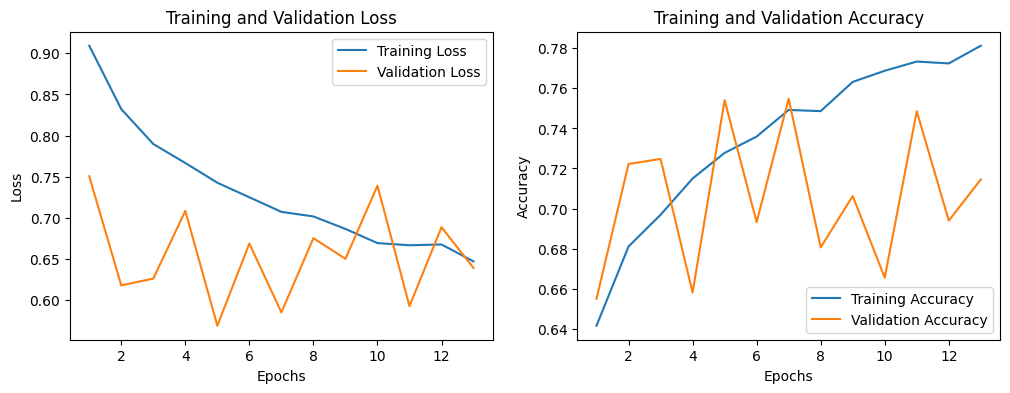

In [27]:
plot_training_results(
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
)

### Experimento 4

In [26]:
import torchvision.transforms.v2 as transforms
from preprocessing.dull_razor import RandomDullRazor

In [27]:
train_transform = transforms.Compose(
    [
        # transforms.RandomResizedCrop(size=280, scale=(0.8, 1.0)),
        transforms.Resize(256, antialias=True,),
        RandomDullRazor.from_image_size(
            (256, 256),
            probability=0.5,
        ),
        transforms.CenterCrop(size=224),
        transforms.RandomAffine(degrees=(-30,30), scale=(1.0, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ColorJitter(
            brightness=(0.7, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            contrast=(0.7, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            saturation=(0.7, 1.3),  # Rango de valores: 0.0 a 1.0 o un solo valor
            hue=(-0.02, 0.02),  # Rango de valores: -0.5 a 0.5
        ),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(256, antialias=True,),
        transforms.CenterCrop(size=224),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=train_transform,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=val_transform,
)

test_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=test_files,
    transform=val_transform,
)

train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=8)
val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=8)

100%|██████████| 35429/35429 [00:00<00:00, 656427.09it/s]


In [33]:
from models.resnet_transfer_learning import get_resnet50_cross_entropy

model, loss, optimizer = get_resnet50_cross_entropy(num_classes=4)

In [34]:
train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model=model,
    optimizer=optimizer,
    criteria=loss,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=15,
    save_every_epoch=3,
    save_path=Path("./saved_models/experiment_4"),
)

Training epoch 1/15: 100%|██████████| 1108/1108 [10:26<00:00,  1.77it/s]

Training Loss: 0.9293
Training Accuracy: 0.6296



Validation on 1/15: 100%|██████████| 211/211 [02:27<00:00,  1.43it/s]


Validation Loss: 0.8063
Validation Accuracy: 0.6284


Training epoch 2/15: 100%|██████████| 1108/1108 [14:21<00:00,  1.29it/s]

Training Loss: 0.8525
Training Accuracy: 0.6664



Validation on 2/15: 100%|██████████| 211/211 [02:29<00:00,  1.41it/s]

Validation Loss: 0.8424
Validation Accuracy: 0.6073



Training epoch 3/15: 100%|██████████| 1108/1108 [14:25<00:00,  1.28it/s]

Training Loss: 0.8235
Training Accuracy: 0.6817



Validation on 3/15: 100%|██████████| 211/211 [02:29<00:00,  1.41it/s]


Validation Loss: 0.7118
Validation Accuracy: 0.6665


Training epoch 4/15: 100%|██████████| 1108/1108 [13:57<00:00,  1.32it/s]

Training Loss: 0.8070
Training Accuracy: 0.6918



Validation on 4/15: 100%|██████████| 211/211 [02:27<00:00,  1.43it/s]

Validation Loss: 0.6616
Validation Accuracy: 0.6902



Training epoch 5/15: 100%|██████████| 1108/1108 [14:00<00:00,  1.32it/s]

Training Loss: 0.7795
Training Accuracy: 0.7077



Validation on 5/15: 100%|██████████| 211/211 [02:26<00:00,  1.44it/s]

Validation Loss: 0.7558
Validation Accuracy: 0.6641



Training epoch 6/15: 100%|██████████| 1108/1108 [13:58<00:00,  1.32it/s]

Training Loss: 0.7718
Training Accuracy: 0.7090



Validation on 6/15: 100%|██████████| 211/211 [02:23<00:00,  1.47it/s]


Validation Loss: 0.6764
Validation Accuracy: 0.6887


Training epoch 7/15: 100%|██████████| 1108/1108 [14:04<00:00,  1.31it/s]

Training Loss: 0.7637
Training Accuracy: 0.7172



Validation on 7/15: 100%|██████████| 211/211 [02:26<00:00,  1.44it/s]

Validation Loss: 0.6579
Validation Accuracy: 0.7007



Training epoch 8/15: 100%|██████████| 1108/1108 [14:03<00:00,  1.31it/s]

Training Loss: 0.7471
Training Accuracy: 0.7250



Validation on 8/15: 100%|██████████| 211/211 [02:23<00:00,  1.48it/s]

Validation Loss: 0.6490
Validation Accuracy: 0.7113



Training epoch 9/15: 100%|██████████| 1108/1108 [14:12<00:00,  1.30it/s]

Training Loss: 0.7349
Training Accuracy: 0.7350



Validation on 9/15: 100%|██████████| 211/211 [02:26<00:00,  1.44it/s]


Validation Loss: 0.6526
Validation Accuracy: 0.7163


Training epoch 10/15: 100%|██████████| 1108/1108 [13:58<00:00,  1.32it/s]

Training Loss: 0.7306
Training Accuracy: 0.7383



Validation on 10/15: 100%|██████████| 211/211 [02:29<00:00,  1.41it/s]

Validation Loss: 0.6533
Validation Accuracy: 0.6981



Training epoch 11/15: 100%|██████████| 1108/1108 [14:00<00:00,  1.32it/s]

Training Loss: 0.7135
Training Accuracy: 0.7422



Validation on 11/15: 100%|██████████| 211/211 [02:23<00:00,  1.47it/s]

Validation Loss: 0.6493
Validation Accuracy: 0.7041



Training epoch 12/15: 100%|██████████| 1108/1108 [14:06<00:00,  1.31it/s]

Training Loss: 0.7086
Training Accuracy: 0.7485



Validation on 12/15: 100%|██████████| 211/211 [02:25<00:00,  1.45it/s]


Validation Loss: 0.6495
Validation Accuracy: 0.6938


Training epoch 13/15:  85%|████████▌ | 944/1108 [27:03<06:19,  2.31s/it]

## Evaluación


In [12]:
from models.resnet_transfer_learning import get_resnet50_cross_entropy

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
import matplotlib.pyplot as plt
import random

def test_model(model, val_dl, num_images, idx_to_class, device="cuda"):
    """
    Test the model with a set of images from the validation dataloader and plot the results.

    Args:
        model: Trained model instance.
        val_dl: Validation dataloader.
        num_images: Number of images to plot.
        idx_to_class: Function or dictionary to convert class indices to class names.
        device: Device to run the model on ("cuda" or "cpu").
    """
    model.to(device)
    model.eval()
    
    # Collect images and labels
    images = []
    true_labels = []
    for batch in val_dl:
        x, y = batch
        images.extend(x)
        true_labels.extend(y)
        if len(images) >= num_images:
            break
    
    # Randomly select the specified number of images
    selected_indices = random.sample(range(len(images)), num_images)
    selected_images = [images[i] for i in selected_indices]
    selected_labels = [true_labels[i] for i in selected_indices]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    with torch.no_grad():
        for i, (img, true_label) in enumerate(zip(selected_images, selected_labels)):
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = idx_to_class(predicted.item())
            true_class = idx_to_class(true_label.item())
            
            ax = axes[i]
            ax.imshow(img.permute(1, 2, 0).cpu().numpy())
            ax.set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
test_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=test_files,
    transform=val_transform,
)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
idx_to_class = test_dataset.int_to_metaclass

loaded_model, _,_ = get_resnet50_cross_entropy(num_classes=4)
loaded_model.load_state_dict(torch.load(f"./saved_models/experiment_3/model_epoch_7.pth", weights_only=True, map_location="cuda:0"))


/home/leismael/.py_environments/python_ai_311/lib64/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [17]:
def extract_paths_and_labels(df: pd.DataFrame) -> tuple[list[str], list[str]]:
    # Verificar que las columnas necesarias existen en el dataframe
    if 'image_path' not in df.columns or 'metaclass' not in df.columns:
        raise ValueError("El dataframe debe contener las columnas 'img_path' y 'metaclass'")
    
    # Extraer las rutas de las imágenes y las clasificaciones
    image_paths = df['image_path'].tolist()
    classifications = df['metaclass'].tolist()
    
    # Devolver la tupla de listas
    return image_paths, classifications

In [18]:
img_paths, expected_labels = extract_paths_and_labels(test_files)

img_paths = [str(get_dataset_image_root() / path) for path in img_paths]

In [19]:
from typing import *
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from torchvision.transforms.v2 import Transform
from torch import Tensor
from PIL import Image
from tqdm import tqdm

def get_metrics(
    image_paths: list[str],
    expected_labels: list[str],
    model,
    transformation: Transform,
    idx_to_class: Callable[[int], str],
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    """
    Get the classification report and confusion matrix for a given set of images.

    Args:
        image_paths: List of image paths.
        expected_labels: List of expected labels.
        model: Trained model instance.
        idx_to_class: Function or dictionary to convert class indices to class names.
        device: Device to run the model on ("cuda" or "cpu").

    Returns:
        Tuple: The classification report and confusion matrix.
    """
    model.to(device)
    model.eval()

    # Get predictions
    predictions = []
    with torch.no_grad():
        for img_p in tqdm(image_paths, total=len(image_paths), desc="Predicting", colour="blue"):
            img = Image.open(img_p)
            img: Tensor = transformation(img)
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = idx_to_class(predicted.item())
            predictions.append(predicted_label)


    # Get classification report
    report = classification_report(expected_labels, predictions)

    # Get confusion matrix
    cm = confusion_matrix(expected_labels, predictions)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    return report, cm

In [33]:
import torchvision.transforms.v2 as transforms

val_transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224),
            antialias=True,
        ),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [34]:
report, cm = get_metrics(
    image_paths=img_paths,
    expected_labels=expected_labels,
    model=loaded_model,
    transformation=val_transform,
    # transformation=train_transform,
    idx_to_class=idx_to_class,
    # device="cuda",
)

Predicting: 100%|██████████| 10547/10547 [04:19<00:00, 40.66it/s]


In [38]:
print(report)

              precision    recall  f1-score   support

         BCC       0.46      0.78      0.58       954
         MEL       0.54      0.52      0.53      1445
       OTHER       0.92      0.81      0.86      7887
         SCC       0.23      0.54      0.32       261

    accuracy                           0.76     10547
   macro avg       0.54      0.66      0.57     10547
weighted avg       0.81      0.76      0.77     10547



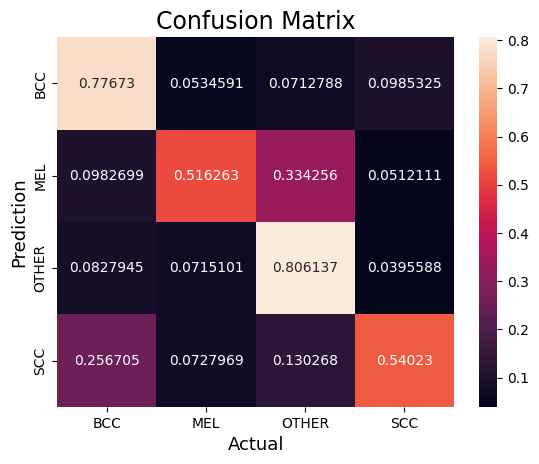

In [36]:
labels = [idx_to_class(i) for i in range(4)]

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()